# 멀티캠퍼스 데이터 사이언스/엔지니어링 0406 코호트 분석 개인 연습

- 코호트 분석을 통해 첫 방문 이후 주차 별 구매율 확인해보기

## 패키지 및 데이터 불러오기

### 패키지 불러오기

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
%config InlineBackend.figure_format = 'retina'

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

### 데이터 불러오기

In [ ]:
DRIVE_PATH = "/content/drive/MyDrive/Multicampus/04_Data Analyze/04_서비스 건강성 분석하기/event_log.csv"

In [ ]:
df = pd.read_csv(DRIVE_PATH)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


## 데이터 전처리

### 분석에 필요한 컬럼만 추출

In [ ]:
df.head(1)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.9,1515915625519388267,LJuJVLEjPT


현재 목적에 맞는 코호트 분석을 위해선, 시간, 이벤트타입, 유저아이디 세가지 데이터만 필요하다. 세 행만 추출하여 사용하도록 한다.

In [ ]:
cols = ["event_time","event_type","user_id"]
df = df[cols]
df.head()

,event_time,event_type,user_id
0,2020-09-24 11:57:06 UTC,view,1515915625519388267
1,2020-09-24 11:57:26 UTC,view,1515915625519380411
2,2020-09-24 11:57:27 UTC,view,1515915625513238515
3,2020-09-24 11:57:33 UTC,view,1515915625519014356
4,2020-09-24 11:57:36 UTC,view,1515915625510743344


### 날짜 데이터 형식 수정

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_time  885129 non-null  object
 1   event_type  885129 non-null  object
 2   user_id     885129 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 20.3+ MB


날짜 데이터의 세부 시간 제거 및 구매일자 데이터 추가

In [ ]:
df.head(1)

,event_time,event_type,user_id
0,2020-09-24 11:57:06 UTC,view,1515915625519388267


In [ ]:
df["first_visit"] = df["event_time"].str[:10]
df["first_visit"] = pd.to_datetime(df["first_visit"],format="%Y-%m-%d")
df.head()

,event_time,event_type,user_id,first_visit
0,2020-09-24 11:57:06 UTC,view,1515915625519388267,2020-09-24
1,2020-09-24 11:57:26 UTC,view,1515915625519380411,2020-09-24
2,2020-09-24 11:57:27 UTC,view,1515915625513238515,2020-09-24
3,2020-09-24 11:57:33 UTC,view,1515915625519014356,2020-09-24
4,2020-09-24 11:57:36 UTC,view,1515915625510743344,2020-09-24


In [ ]:
df["purchase"] = df["first_visit"]

In [ ]:
del df["event_time"]

In [ ]:
df.head()

,event_type,user_id,first_visit,purchase
0,view,1515915625519388267,2020-09-24,2020-09-24
1,view,1515915625519380411,2020-09-24,2020-09-24
2,view,1515915625513238515,2020-09-24,2020-09-24
3,view,1515915625519014356,2020-09-24,2020-09-24
4,view,1515915625510743344,2020-09-24,2020-09-24


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   event_type   885129 non-null  object        
 1   user_id      885129 non-null  int64         
 2   first_visit  885129 non-null  datetime64[ns]
 3   purchase     885129 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 27.0+ MB


### 유저 별 첫 방문일 조회

#### view 데이터 추출

첫 방문일 데이터를 추출하기 위해, `event_type`이 `view`인 데이터들을 따로 수집

In [ ]:
mask = df["event_type"] == "view"
df_first_visit = df[mask]
df_first_visit.head()

,event_type,user_id,first_visit,purchase
0,view,1515915625519388267,2020-09-24,2020-09-24
1,view,1515915625519380411,2020-09-24,2020-09-24
2,view,1515915625513238515,2020-09-24,2020-09-24
3,view,1515915625519014356,2020-09-24,2020-09-24
4,view,1515915625510743344,2020-09-24,2020-09-24


#### 첫 방문일자 구하기

In [ ]:
df_first_visit = df_first_visit.set_index("user_id")
df_first_visit = df_first_visit.groupby(df_first_visit.index)['first_visit'].min().to_frame()
df_first_visit.head()

,first_visit
user_id,
1515915625353226922,2020-10-29
1515915625353230067,2020-10-06
1515915625353230683,2020-11-09
1515915625353230922,2020-10-02
1515915625353234047,2020-09-29


In [ ]:
df_first_visit.sort_values(by="first_visit",inplace = True)
df_first_visit.tail()

,first_visit
user_id,
1515915625610763148,2021-02-28
1515915625610763218,2021-02-28
1515915625610763615,2021-02-28
1515915625610763853,2021-02-28
1515915625611024030,2021-02-28


In [ ]:
df_first_visit = df_first_visit.reset_index()
df_first_visit.tail()

,user_id,first_visit
406858,1515915625610763148,2021-02-28
406859,1515915625610763218,2021-02-28
406860,1515915625610763615,2021-02-28
406861,1515915625610763853,2021-02-28
406862,1515915625611024030,2021-02-28


In [ ]:
df_first_visit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406863 entries, 0 to 406862
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      406863 non-null  int64         
 1   first_visit  406863 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.2 MB


### 첫 방문일에 따른 구매 일자 조회

In [ ]:
mask = df["event_type"] == "purchase"
df_purchase = df[mask]
del df_purchase["first_visit"]
del df_purchase["event_type"]
df_purchase.head()

,user_id,purchase
45,1515915625519390468,2020-09-24
82,1515915625513574486,2020-09-24
100,1515915625518130982,2020-09-24
132,1515915625518130982,2020-09-24
150,1515915625519356010,2020-09-24


In [ ]:
df_purchase.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37346 entries, 45 to 885096
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   37346 non-null  int64         
 1   purchase  37346 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 875.3 KB


### 첫 방문일 데이터에 구매 일자 데이터 합체

#### 주별 데이터로 변환 및 첫 주, 마지막 주 데이터 처리

In [ ]:
df_first_visit.head()

,user_id,first_visit
0,1515915625512033512,2020-09-24
1,1515915625519493078,2020-09-24
2,1515915625482978862,2020-09-24
3,1515915625519492764,2020-09-24
4,1515915625519492425,2020-09-24


In [ ]:
df_purchase.head()

,user_id,purchase
45,1515915625519390468,2020-09-24
82,1515915625513574486,2020-09-24
100,1515915625518130982,2020-09-24
132,1515915625518130982,2020-09-24
150,1515915625519356010,2020-09-24


In [ ]:
df_first_visit["first_visit"] = df_first_visit["first_visit"].dt.strftime("%Y-w%U")
df_purchase["purchase"] = df_purchase["purchase"].dt.strftime("%Y-w%U")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_first_visit.groupby("first_visit")["user_id"].nunique()

first_visit
2020-w38     5638
2020-w39    16376
2020-w40    15926
2020-w41    18482
2020-w42    21180
2020-w43    20861
2020-w44    21840
2020-w45    22535
2020-w46    24016
2020-w47    17114
2020-w48    15502
2020-w49    15123
2020-w50    16794
2020-w51    16663
2020-w52    13370
2021-w01    17009
2021-w02    18885
2021-w03    18576
2021-w04    17804
2021-w05    18986
2021-w06    18185
2021-w07    17255
2021-w08    16371
2021-w09     2372
Name: user_id, dtype: int64

In [ ]:
df_first_visit1 = df_first_visit.copy()

In [ ]:
OLD_YEAR_WEEK_NUMBER = "2021-w00"
NEW_YEAR_WEEK_NUMBER = "2020-w52"

df_first_visit.loc[df_first_visit["first_visit"] == OLD_YEAR_WEEK_NUMBER, "first_visit"] = NEW_YEAR_WEEK_NUMBER

mask = (df_first_visit["first_visit"] == "2020-w38") | (df_first_visit["first_visit"] == "2021-w09")
df_first_visit = df_first_visit.loc[~mask]

df_first_visit.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,user_id,first_visit
5638,1515915625520311943,2020-w39
5639,1515915625520121456,2020-w39
5640,1515915625520126342,2020-w39
5641,1515915625520120691,2020-w39
5642,1515915625520119369,2020-w39


In [ ]:
df_purchase.loc[df_purchase["purchase"] == OLD_YEAR_WEEK_NUMBER, "purchase"] = NEW_YEAR_WEEK_NUMBER

mask = (df_purchase["purchase"] == "2020-w38") | (df_purchase["purchase"] == "2021-w09")
df_purchase = df_purchase.loc[~mask]

df_purchase.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,user_id,purchase
10094,1515915625520122399,2020-w39
10101,1515915625520122399,2020-w39
10144,1515915625515148783,2020-w39
10148,1515915625515148783,2020-w39
10176,1515915625520127803,2020-w39


In [ ]:
df_first_visit.head()

,user_id,first_visit
5638,1515915625520311943,2020-w39
5639,1515915625520121456,2020-w39
5640,1515915625520126342,2020-w39
5641,1515915625520120691,2020-w39
5642,1515915625520119369,2020-w39


In [ ]:
df_first_visit.groupby("first_visit")["user_id"].nunique()

first_visit
2020-w39    16376
2020-w40    15926
2020-w41    18482
2020-w42    21180
2020-w43    20861
2020-w44    21840
2020-w45    22535
2020-w46    24016
2020-w47    17114
2020-w48    15502
2020-w49    15123
2020-w50    16794
2020-w51    16663
2020-w52    13370
2021-w01    17009
2021-w02    18885
2021-w03    18576
2021-w04    17804
2021-w05    18986
2021-w06    18185
2021-w07    17255
2021-w08    16371
Name: user_id, dtype: int64

In [ ]:
df_purchase.groupby("purchase")["user_id"].nunique()

purchase
2020-w39     726
2020-w40     784
2020-w41     823
2020-w42    1003
2020-w43     946
2020-w44     999
2020-w45    1211
2020-w46    1123
2020-w47     872
2020-w48     832
2020-w49     766
2020-w50    1012
2020-w51    1005
2020-w52     803
2021-w01     955
2021-w02    1243
2021-w03    1253
2021-w04    1176
2021-w05    1064
2021-w06    1170
2021-w07    1152
2021-w08    1067
Name: user_id, dtype: int64

#### 첫 방문 주 데이터와 구매 주차 데이터 결합 

In [ ]:
df_joined = pd.merge(df_first_visit, df_purchase, how='left', on="user_id")
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414461 entries, 0 to 414460
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      414461 non-null  int64 
 1   first_visit  414461 non-null  object
 2   purchase     36102 non-null   object
dtypes: int64(1), object(2)
memory usage: 12.6+ MB


#### 구매 주차가 첫 방문보다 앞선 데이터 삭제

어떠한 이유로 구매 행위를 하고도 view에 집계되지 않은 데이터들에 대하여 삭제 처리

또한 어떤 이유에선지 drop 메소드가 사용되지 않아, 매우 번거로운 방법으로 삭제를 진행함

In [ ]:
df_joined1=df_joined.copy()

In [ ]:
df_joined = df_joined1.copy()

In [ ]:
del_indicies = []
for i in range(len(df_joined)):
  if pd.isnull(df_joined["purchase"][i]) == False:
    if df_joined["first_visit"][i][:4] >= df_joined["purchase"][i][:4]:

      if df_joined["first_visit"][i][6:] > df_joined["purchase"][i][6:]:
        del_indicies.append(df_joined.index[i])

In [ ]:
indicies = set(list(range(len(df_joined))))
indicies.difference(set(del_indicies))
indicies = list(indicies)
len(indicies)

414461

In [ ]:
remained_indicies = list(set(indicies) - set(del_indicies))
remained_indicies.sort()

In [ ]:
len(remained_indicies)

414441

In [ ]:
df_joined = df_joined.loc[remained_indicies]

In [ ]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414441 entries, 0 to 414460
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      414441 non-null  int64 
 1   first_visit  414441 non-null  object
 2   purchase     36082 non-null   object
dtypes: int64(1), object(2)
memory usage: 12.6+ MB


### 코호트 분석에 맞는 형태로 변환

#### 몇주차인지 계산하기

In [ ]:
cohorts = pd.DataFrame(df_joined.groupby(["first_visit", "purchase"])["user_id"].nunique())
cohorts.head(10)

user_id
first_visit purchase         
2020-w39    2020-w39      669
            2020-w40       41
            2020-w41       12
            2020-w42       14
            2020-w43        7
            2020-w44        5
            2020-w45        5
            2020-w46        4
            2020-w47        1
            2020-w48        2

In [ ]:
cohorts = cohorts.reset_index()

In [ ]:
lst = []
for i in range(len(cohorts)):
  if (int(cohorts['purchase'][i][-2:])-int(cohorts['first_visit'][i][-2:])) < 0:
    lst.append((int(cohorts['purchase'][i][-2:])-int(cohorts['first_visit'][i][-2:]))+52)
  else:
    lst.append((int(cohorts['purchase'][i][-2:])-int(cohorts['first_visit'][i][-2:])))
print(lst)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 17, 19, 20, 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 2, 0, 1, 0]


In [ ]:
cohorts["week_diff"] = lst
cohorts

,first_visit,purchase,user_id,week_diff
0,2020-w39,2020-w39,669,0
1,2020-w39,2020-w40,41,1
2,2020-w39,2020-w41,12,2
3,2020-w39,2020-w42,14,3
4,2020-w39,2020-w43,7,4
...,...,...,...,...
230,2021-w06,2021-w07,56,1
231,2021-w06,2021-w08,23,2
232,2021-w07,2021-w07,969,0
233,2021-w07,2021-w08,63,1


#### 첫 방문자 수 데이터 결합

In [ ]:
cohorts = cohorts.merge(pd.DataFrame(df_first_visit.groupby("first_visit")["user_id"].nunique()).rename(columns={"user_id":"first_visitors"}),on = "first_visit")

In [ ]:
cohorts.rename(columns={"user_id":"purchase_count"},inplace=True)

In [ ]:
cohorts

,first_visit,purchase,purchase_count,week_diff,first_visitors
0,2020-w39,2020-w39,669,0,16376
1,2020-w39,2020-w40,41,1,16376
2,2020-w39,2020-w41,12,2,16376
3,2020-w39,2020-w42,14,3,16376
4,2020-w39,2020-w43,7,4,16376
...,...,...,...,...,...
230,2021-w06,2021-w07,56,1,18185
231,2021-w06,2021-w08,23,2,18185
232,2021-w07,2021-w07,969,0,17255
233,2021-w07,2021-w08,63,1,17255


In [ ]:
cohorts['first_visitors']=cohorts['first_visitors'].astype(str)

In [ ]:
cohorts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235 entries, 0 to 234
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   first_visit     235 non-null    object
 1   purchase        235 non-null    object
 2   purchase_count  235 non-null    int64 
 3   week_diff       235 non-null    int64 
 4   first_visitors  235 non-null    object
dtypes: int64(2), object(3)
memory usage: 11.0+ KB


#### 형태 변환

In [ ]:
cohorts1 = cohorts.set_index(["first_visit","first_visitors", "week_diff"])
cohorts1

purchase  purchase_count
first_visit first_visitors week_diff                          
2020-w39    16376          0          2020-w39             669
                           1          2020-w40              41
                           2          2020-w41              12
                           3          2020-w42              14
                           4          2020-w43               7
...                                        ...             ...
2021-w06    18185          1          2021-w07              56
                           2          2021-w08              23
2021-w07    17255          0          2021-w07             969
                           1          2021-w08              63
2021-w08    16371          0          2021-w08             885

[235 rows x 2 columns]

In [ ]:
cohorts1 = cohorts1["purchase_count"].unstack(2)

## 코호트 분석 표

### 수치로 나타낸 표

In [ ]:
cohorts1

,week_diff,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
first_visit,first_visitors,,,,,,,,,,,,,,,,,,,,,
2020-w39,16376,669.0,41.0,12.0,14.0,7.0,5.0,5.0,4.0,1.0,2.0,...,1.0,2.0,NaN,2.0,4.0,NaN,1.0,1.0,1.0,1.0
2020-w40,15926,691.0,48.0,11.0,9.0,8.0,11.0,6.0,4.0,5.0,1.0,...,NaN,NaN,1.0,1.0,NaN,NaN,2.0,NaN,1.0,1.0
2020-w41,18482,720.0,46.0,10.0,16.0,8.0,2.0,NaN,1.0,2.0,2.0,...,2.0,1.0,3.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN
2020-w42,21180,909.0,43.0,13.0,12.0,7.0,8.0,3.0,6.0,5.0,2.0,...,4.0,7.0,3.0,3.0,NaN,1.0,4.0,1.0,NaN,NaN
2020-w43,20861,863.0,42.0,21.0,10.0,9.0,8.0,3.0,7.0,7.0,7.0,...,2.0,1.0,3.0,2.0,2.0,3.0,1.0,NaN,NaN,NaN
2020-w44,21840,893.0,82.0,17.0,12.0,5.0,4.0,6.0,2.0,NaN,1.0,...,3.0,1.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2020-w45,22535,1060.0,64.0,22.0,12.0,9.0,3.0,3.0,2.0,5.0,5.0,...,3.0,3.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
2020-w46,24016,994.0,54.0,19.0,15.0,6.0,4.0,8.0,6.0,5.0,6.0,...,6.0,6.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-w47,17114,747.0,51.0,15.0,8.0,8.0,5.0,3.0,6.0,4.0,4.0,...,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 비율로 나타낸 표

#### 계산

In [ ]:
cohorts2 = cohorts.copy()

In [ ]:
cohorts2["ratio"] = cohorts2['purchase_count'] / cohorts2['first_visitors'].astype(int)

In [ ]:
del cohorts2['purchase_count']

In [ ]:
cohorts2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235 entries, 0 to 234
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   first_visit     235 non-null    object 
 1   purchase        235 non-null    object 
 2   week_diff       235 non-null    int64  
 3   first_visitors  235 non-null    object 
 4   ratio           235 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 11.0+ KB


In [ ]:
cohorts2

,first_visit,purchase,week_diff,first_visitors,ratio
0,2020-w39,2020-w39,0,16376,0.040852
1,2020-w39,2020-w40,1,16376,0.002504
2,2020-w39,2020-w41,2,16376,0.000733
3,2020-w39,2020-w42,3,16376,0.000855
4,2020-w39,2020-w43,4,16376,0.000427
...,...,...,...,...,...
230,2021-w06,2021-w07,1,18185,0.003079
231,2021-w06,2021-w08,2,18185,0.001265
232,2021-w07,2021-w07,0,17255,0.056158
233,2021-w07,2021-w08,1,17255,0.003651


In [ ]:
cohorts2 = cohorts2.set_index(["first_visit","first_visitors", "week_diff"])
cohorts2

purchase     ratio
first_visit first_visitors week_diff                    
2020-w39    16376          0          2020-w39  0.040852
                           1          2020-w40  0.002504
                           2          2020-w41  0.000733
                           3          2020-w42  0.000855
                           4          2020-w43  0.000427
...                                        ...       ...
2021-w06    18185          1          2021-w07  0.003079
                           2          2021-w08  0.001265
2021-w07    17255          0          2021-w07  0.056158
                           1          2021-w08  0.003651
2021-w08    16371          0          2021-w08  0.054059

[235 rows x 2 columns]

In [ ]:
cohorts2 = cohorts2["ratio"].unstack(2)

#### 표 생성

In [ ]:
cohorts2

,week_diff,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
first_visit,first_visitors,,,,,,,,,,,,,,,,,,,,,
2020-w39,16376,0.040852,0.002504,0.000733,0.000855,0.000427,0.000305,0.000305,0.000244,0.000061,0.000122,...,0.000061,0.000122,NaN,0.000122,0.000244,NaN,0.000061,0.000061,0.000061,0.000061
2020-w40,15926,0.043388,0.003014,0.000691,0.000565,0.000502,0.000691,0.000377,0.000251,0.000314,0.000063,...,NaN,NaN,0.000063,0.000063,NaN,NaN,0.000126,NaN,0.000063,0.000063
2020-w41,18482,0.038957,0.002489,0.000541,0.000866,0.000433,0.000108,NaN,0.000054,0.000108,0.000108,...,0.000108,0.000054,0.000162,NaN,0.000054,NaN,0.000054,0.000054,NaN,NaN
2020-w42,21180,0.042918,0.002030,0.000614,0.000567,0.000331,0.000378,0.000142,0.000283,0.000236,0.000094,...,0.000189,0.000331,0.000142,0.000142,NaN,0.000047,0.000189,0.000047,NaN,NaN
2020-w43,20861,0.041369,0.002013,0.001007,0.000479,0.000431,0.000383,0.000144,0.000336,0.000336,0.000336,...,0.000096,0.000048,0.000144,0.000096,0.000096,0.000144,0.000048,NaN,NaN,NaN
2020-w44,21840,0.040888,0.003755,0.000778,0.000549,0.000229,0.000183,0.000275,0.000092,NaN,0.000046,...,0.000137,0.000046,0.000092,0.000046,NaN,0.000046,NaN,NaN,NaN,NaN
2020-w45,22535,0.047038,0.002840,0.000976,0.000533,0.000399,0.000133,0.000133,0.000089,0.000222,0.000222,...,0.000133,0.000133,0.000044,0.000089,0.000089,NaN,NaN,NaN,NaN,NaN
2020-w46,24016,0.041389,0.002249,0.000791,0.000625,0.000250,0.000167,0.000333,0.000250,0.000208,0.000250,...,0.000250,0.000250,0.000167,0.000042,NaN,NaN,NaN,NaN,NaN,NaN
2020-w47,17114,0.043648,0.002980,0.000876,0.000467,0.000467,0.000292,0.000175,0.000351,0.000234,0.000234,...,0.000175,0.000234,0.000175,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 코호트 분석 히트맵

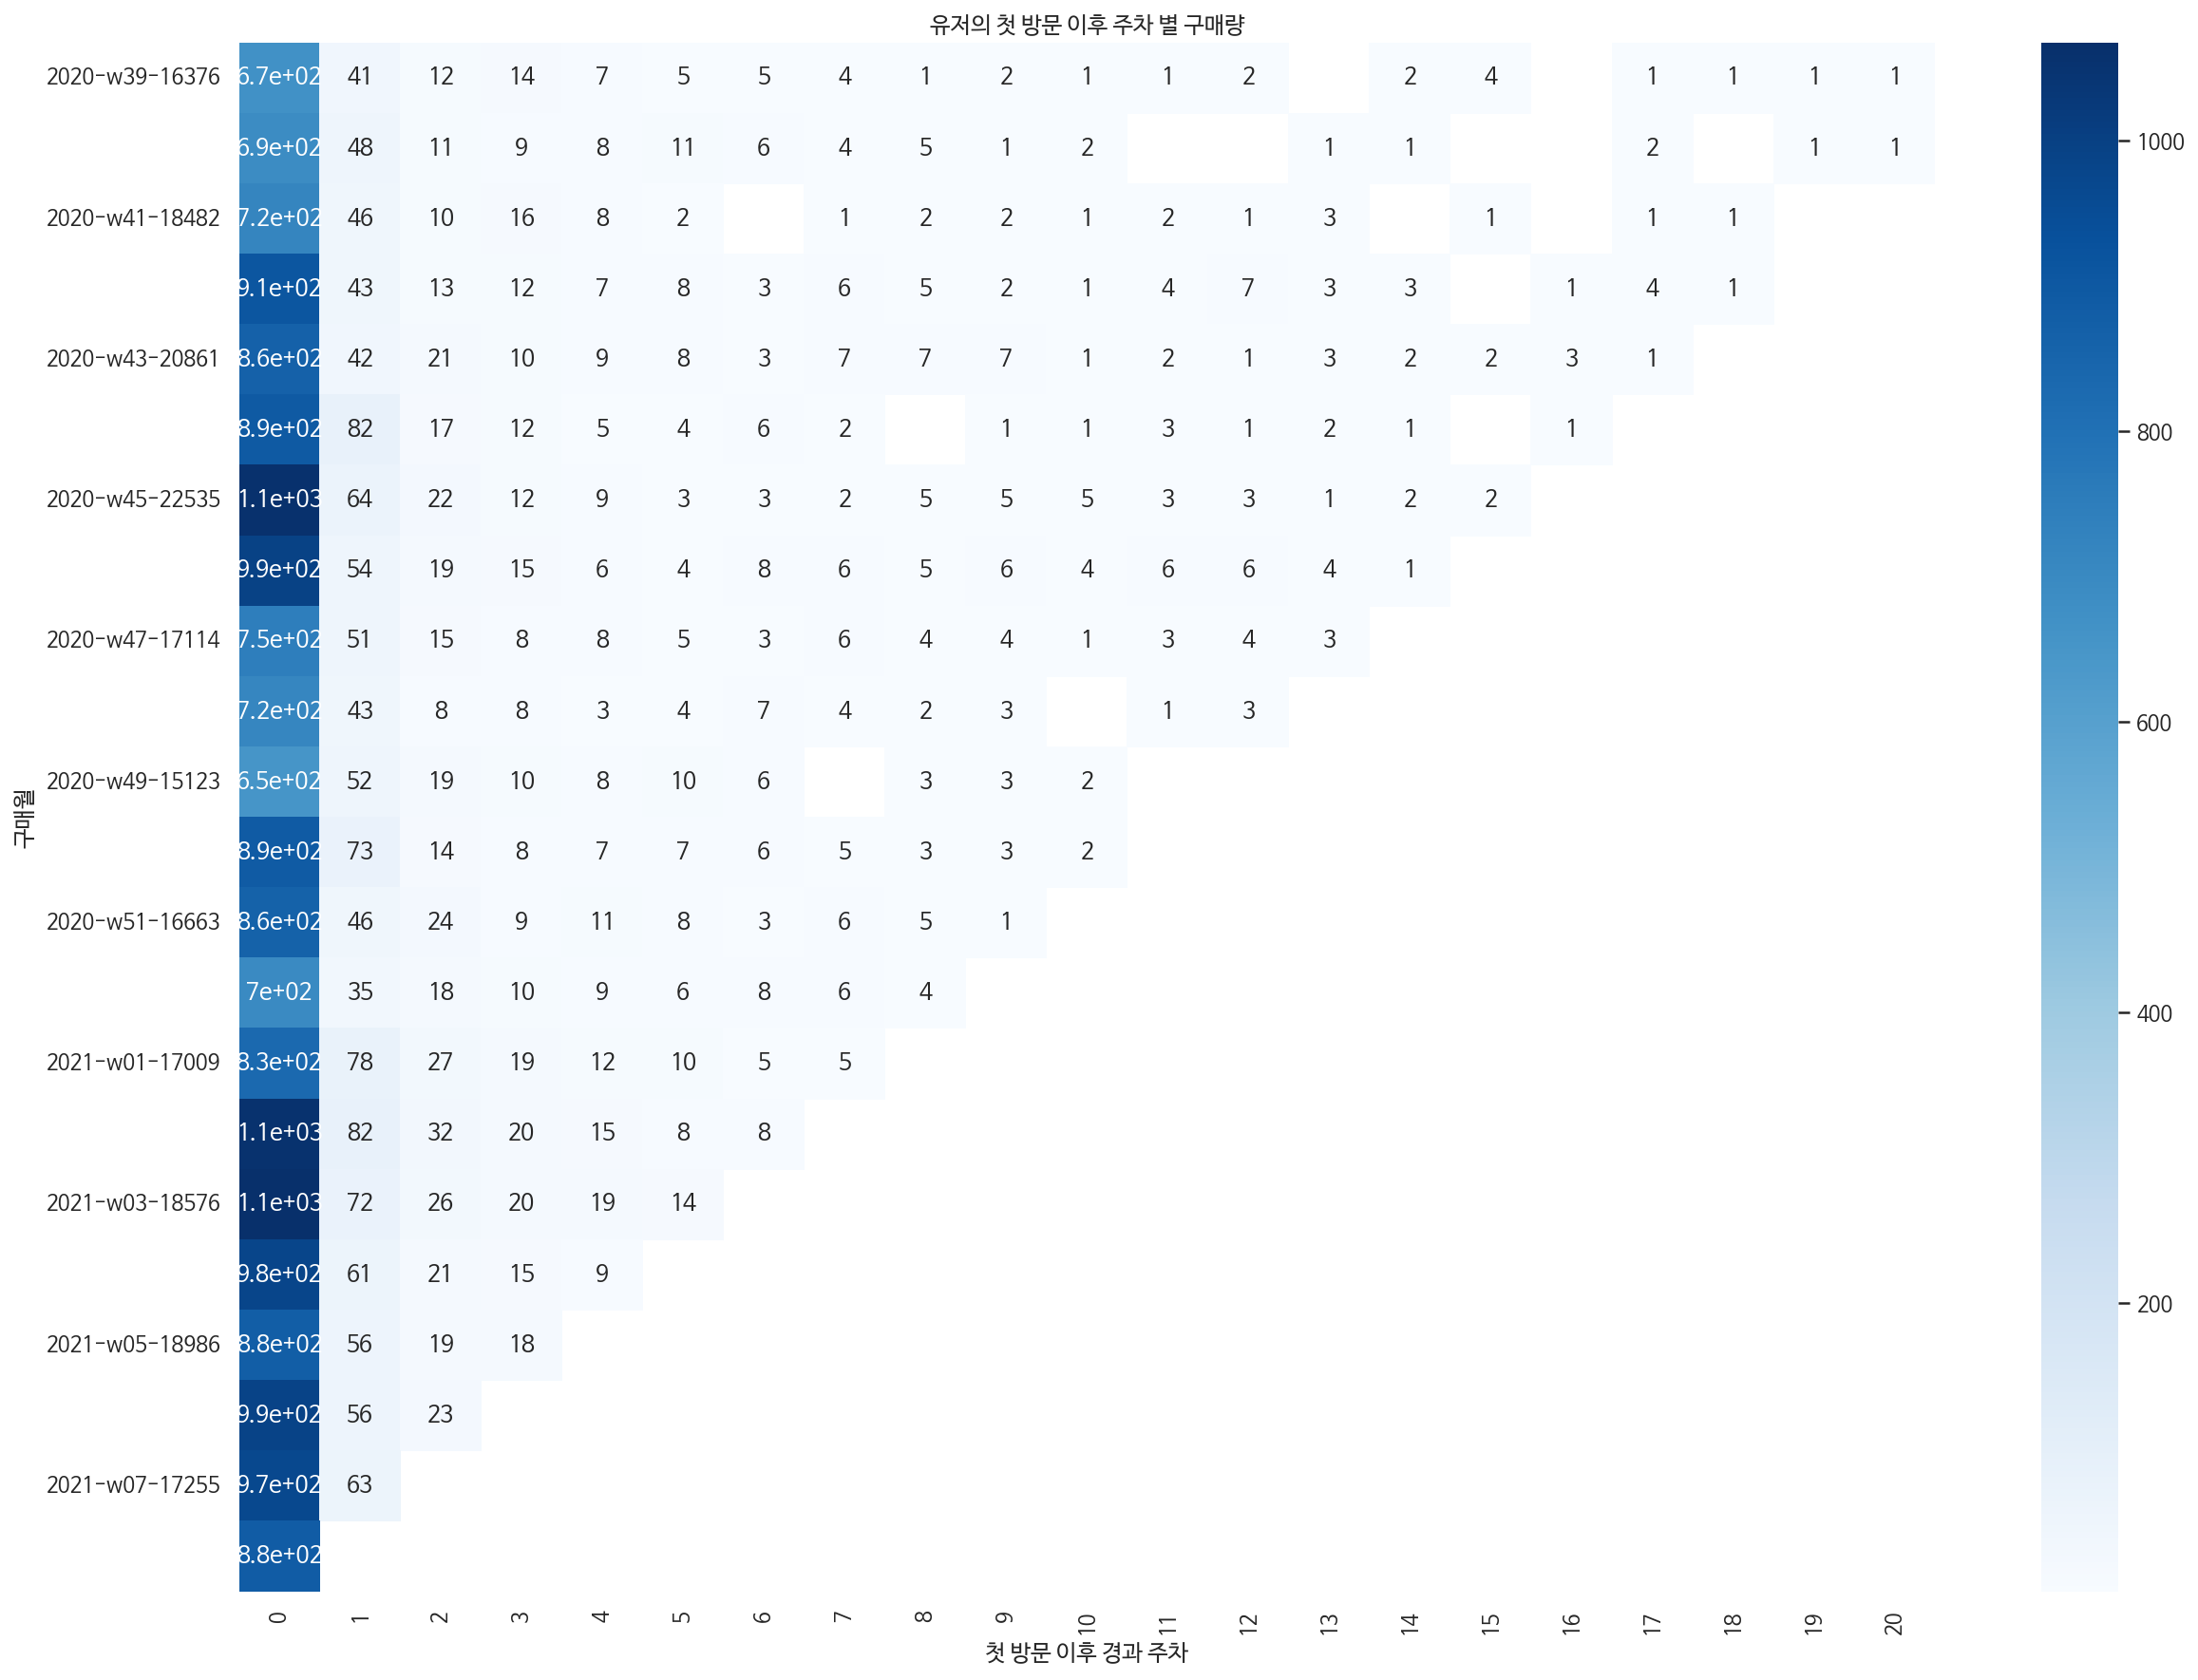

In [ ]:
sns.set_theme( style="whitegrid", palette="pastel" )
plt.rc('font', family='NanumBarunGothic')

g = sns.heatmap(cohorts1, annot = True, cmap = "Blues")

g.figure.set_size_inches(20,15)
g.set_title("유저의 첫 방문 이후 주차 별 구매량")
g.set_xlabel("첫 방문 이후 경과 주차")
g.set_ylabel("구매월")

plt.show()

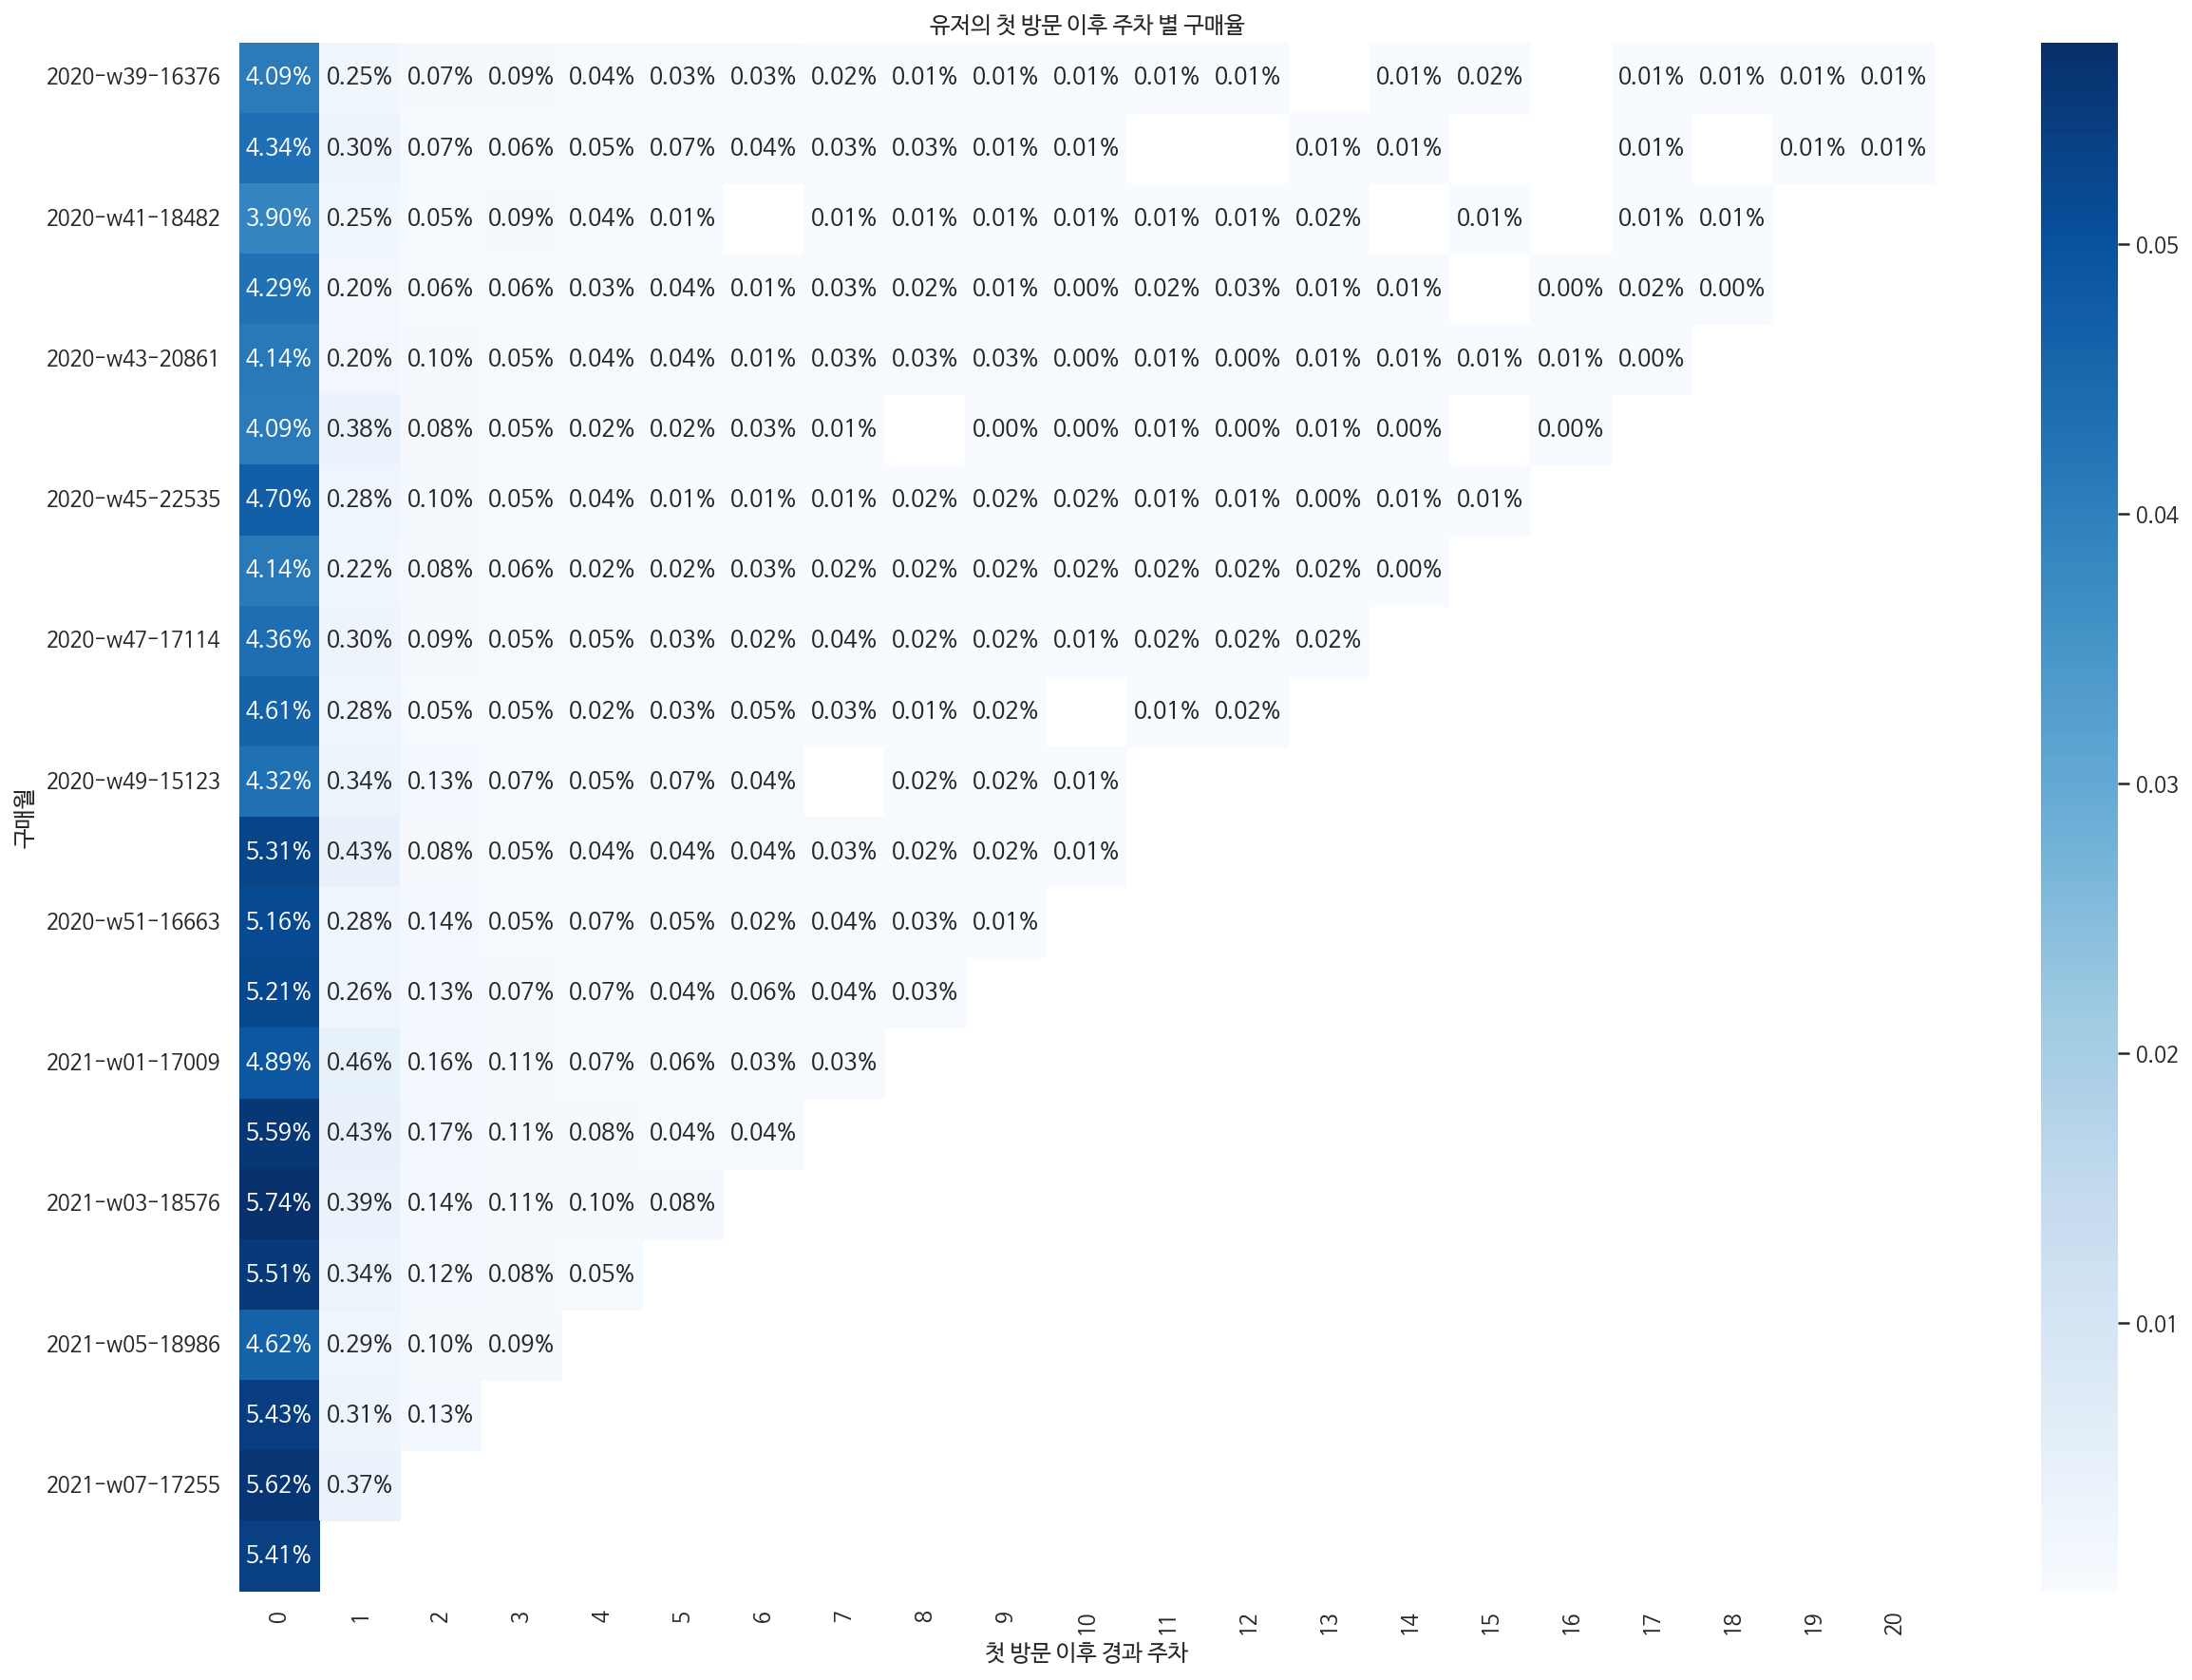

In [ ]:
sns.set_theme( style="whitegrid", palette="pastel" )
plt.rc('font', family='NanumBarunGothic')

g = sns.heatmap(cohorts2, annot = True, fmt = ".2%", cmap = "Blues")

g.figure.set_size_inches(20,15)
g.set_title("유저의 첫 방문 이후 주차 별 구매율")
g.set_xlabel("첫 방문 이후 경과 주차")
g.set_ylabel("구매월")

plt.show()